# Amazon Machine Learning Demonstration


https://aws.amazon.com/pt/machine-learning/
Amazon Machine Learning is a service that makes it easy for developers of all skill levels to use machine learning technology. Amazon Machine Learning provides visualization tools and wizards that guide you through the process of creating machine learning (ML) models without having to learn complex ML algorithms and technology.
With Amazon Machine Learning you can train three different types of models, using the following algorithms:
 - Binary Logistic Regression
 - Multinomial Logistic Regression
 - Linear Regression
 
We will use Multinomial Logistic Regression to create a model for predicting the category of a product, given its short descriptiion.

Python Boto3 reference:
http://boto3.readthedocs.io/en/latest/reference/services/machinelearning.html

## Goal: to create a model to predict a given product category

Model:
 - Input: product short description
 - Output: category
 - *predict_categoria(product_name) -> category*
 

In [59]:
%matplotlib inline

import boto3
import numpy as np
import pandas as pd
import sagemaker
import IPython.display as disp
import json

from time import gmtime, strftime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from IPython.display import Markdown
from notebook import notebookapp

In [2]:
# Get the current Sagemaker session
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

In [16]:
s3_bucket = sagemaker_session.default_bucket()
client = boto3.client('machinelearning')
s3_client = boto3.client('s3')
s3 = boto3.client('s3')
base_dir='/tmp/aml'

In [39]:
bucket_arn = "arn:aws:s3:::%s/*" % s3_bucket
policy_statement = {
    "Sid": "AddPerm",
    "Effect": "Allow",
    "Principal": "*",
    "Action": "s3:GetObject",
    "Resource": bucket_arn
}

In [46]:
current_policy = None
try:
    current_policy = json.loads(s3_client.get_bucket_policy(Bucket=s3_bucket)['Policy'])
    policy_found = False
    for st in current_policy['Statement']:
        if st["Action"] == "s3:GetObject" and st["Resource"] == bucket_arn:
            policy_found = True
            break

    if not policy_found:
        current_policy['Statement'].append( bucket_statement )
except Exception as e:
    print("There is no current policy. Adding one...")
    s3_client.put_bucket_policy(
        Bucket=s3_bucket,
        Policy=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [policy_statement]
            }
        )
    )

# Data Scientist moment
## Preparing the dataset

In [47]:
!mkdir -p $base_dir
!curl -s https://workshopml.spock.cloud/datasets/products/aml_data.tar.gz | tar -xz -C $base_dir

In [48]:
data = pd.read_csv(base_dir + '/sample.csv', sep=',', encoding='utf-8')
print( len(data) )
data.iloc[[517, 163, 14, 826, 692]]

957


,product_name,main_category,sub_category
517,Blusa Ecko Ad.Basic Color All City Vandals Cinza,vestuarios,blusa
163,Touca Black Flag Cinza,acessorios,touca
14,Camiseta Advance Gangster Preta,vestuarios,camiseta
826,Canguru Cotton Line Vermelho KaBaby,acessorios,canguru
692,Saia GarotaFit Tricolor Rosa,vestuarios,saia


### So, we need to remove accents, transform everything to lower case and remove stopwords

In [49]:
# tranlating table for removing accents
accents = "".maketrans("áàãâéêíóôõúüçÁÀÃÂÉÊÍÓÔÕÚÜÇ", "aaaaeeiooouucAAAAEEIOOOUUC")

# loading stopwords without accents
file = open("stopwords.txt", "r")
stopwords = list(map(lambda x:x.strip().translate(accents),file.readlines()))
file.close()

In [50]:
# this tokenizer will tokenize the text, remove stop words and compute bigrams (ngram(2))
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='word', stop_words=stopwords, token_pattern='[a-zA-Z]+')
tokenizer = word_vectorizer.build_tokenizer()

def remove_stop_words(text):
    return " ".join( list(filter( lambda x: x not in stopwords, tokenizer(text) )) )

In [51]:
data['product_name_tokens'] = list(map(lambda x: remove_stop_words( x.lower().translate(accents) ), data['product_name']))
data['main_category_tokens'] = list(map(lambda x: remove_stop_words( x.lower().translate(accents) ), data['main_category']))
data['subcategory_tokens'] = list(map(lambda x: remove_stop_words( x.lower().translate(accents) ), data['sub_category']))

In [52]:
data.iloc[[26, 163, 14, 826, 692]]

,product_name,main_category,sub_category,product_name_tokens,main_category_tokens,subcategory_tokens
26,Kit de Mergulho Premium Ahead Sports Winmax Ve...,acessorios,kit,kit mergulho premium ahead sports winmax vermelho,acessorios,kit
163,Touca Black Flag Cinza,acessorios,touca,touca black flag cinza,acessorios,touca
14,Camiseta Advance Gangster Preta,vestuarios,camiseta,camiseta advance gangster preta,vestuarios,camiseta
826,Canguru Cotton Line Vermelho KaBaby,acessorios,canguru,canguru cotton line vermelho kababy,acessorios,canguru
692,Saia GarotaFit Tricolor Rosa,vestuarios,saia,saia garotafit tricolor rosa,vestuarios,saia


## Let's remove the unecessary columns

In [53]:
data_final = data[ [ 'product_name_tokens', 'main_category_tokens', 'subcategory_tokens' ]]
data_final = data_final.rename(columns={
    "product_name_tokens": "product_name", 
    "main_category_tokens": "category",
    "subcategory_tokens": "sub_category", 
})
data_final.head()

,product_name,category,sub_category
0,saa praia resort wear estampada,vestuarios,saida praia
1,vestido resort wear estampado preto,vestuarios,vestido
2,brinquedo artesanal casa rvore multicolorido,acessorios,brinquedo
3,camiseta life the poet musgo,vestuarios,camiseta
4,camiseta life boomer vermelha,vestuarios,camiseta


# Ok. We finished our 'sample' dataset preparation.
## Now, lets continue with the dataset that was already cleaned.
## In real life, you should apply all these transformations to your final dataset.

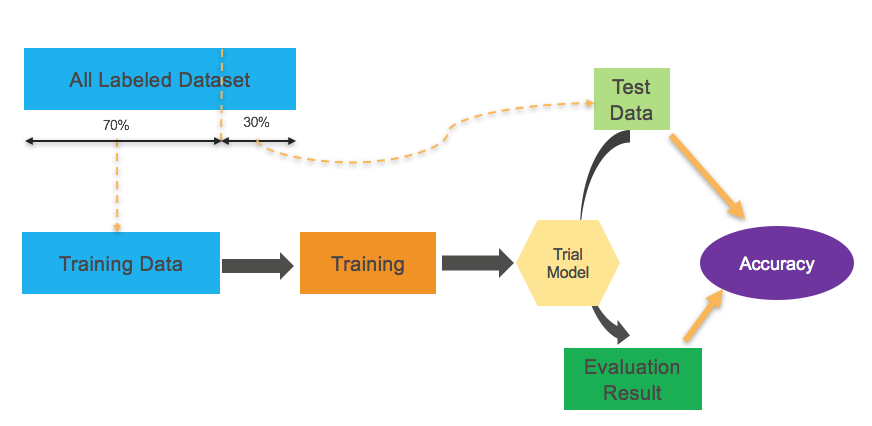

In [54]:
disp.Image(base_dir + '/workflow_processo.png')

### Now, lets execute the steps above, using Amazon Machine Learning.

In [55]:
# First, lets upload our dataset to S3
s3.upload_file( base_dir + '/dataset.csv', s3_bucket, 'workshop/AML/dataset.csv' )

In [56]:
# just take a look on that, before continue
pd.read_csv(base_dir + '/dataset.csv', sep=',', encoding='utf-8').head()

,product_name,category,sub_category
0,brinco joia casa flor pendurada oval dourado,acessorios,brinco
1,chapeu chapelaria vintage panama natural,acessorios,chapeu
2,sapatilha fiveblu lisa preta,calcados,sapatilha
3,tenis converse ct bright hi azul,calcados,tenis
4,camiseta emitresde drone rosa,vestuarios,camiseta


## Now, lets create the DataSources
### Before that, we need to split it into 70% training and 30% test

In [57]:
strategy_train = open( 'split_strategy_training.json', 'r').read()
strategy_test = open( 'split_strategy_test.json', 'r').read()
print( "Training: {}\nTest: {}".format( strategy_train, strategy_test ) )

Training: {
  "splitting": {
    "percentBegin": 0,
    "percentEnd": 70,
    "strategy": "random"
  }
}

Test: {
  "splitting": {
    "percentBegin": 70,
    "percentEnd": 100,
    "strategy": "random"
  }
}



### How AML knows the file format (CSV)? By using the schema bellow...

In [58]:
categorias_schema = open('category_schema.json', 'r').read()
print( "Formato dos dados do dataset: {}\n".format( categorias_schema) )

Formato dos dados do dataset: {

    "version": "1.0",
    "rowId": null,
    "rowWeight": null,
    "targetAttributeName": "category",
    "dataFormat": "CSV",
    "dataFileContainsHeader": true,
    "attributes": [
        {
            "attributeName": "product_name",
            "attributeType": "TEXT"
        },
        {
            "attributeName": "category",
            "attributeType": "CATEGORICAL"
        },
        {
            "attributeName": "sub_category",
            "attributeType": "CATEGORICAL"
        }
    ],
    "excludedAttributeNames": [ ]

}




### Creating the DataSources (train and test) for the Category Model

In [106]:
train_datasource_name = 'CategoriasTrain' + '_' + strftime("%Y%m%d_%H%M%S", gmtime())
test_datasource_name = 'CategoriasTest' + '_' + strftime("%Y%m%d_%H%M%S", gmtime())

print(train_datasource_name, test_datasource_name)

resp = client.create_data_source_from_s3(
    DataSourceId=train_datasource_name,
    DataSourceName=train_datasource_name,
    DataSpec={
        'DataLocationS3': 's3://%s/workshop/AML/dataset.csv' % s3_bucket,
        'DataSchema': categorias_schema,
        'DataRearrangement': strategy_train
    },
    ComputeStatistics=True
)

resp = client.create_data_source_from_s3(
    DataSourceId=test_datasource_name,
    DataSourceName=test_datasource_name,
    DataSpec={
        'DataLocationS3': 's3://%s/workshop/AML/dataset.csv' % s3_bucket,
        'DataSchema': categorias_schema,
        'DataRearrangement': strategy_test
    },
    ComputeStatistics=True
)

waiter = client.get_waiter('data_source_available')
waiter.wait(FilterVariable='Name', EQ=train_datasource_name)
waiter.wait(FilterVariable='Name', EQ=test_datasource_name)
print( "Datasources created successfully!" )

CategoriasTrain_20180327_231037 CategoriasTest_20180327_231037
Datasources created successfully!


## Creating/training the Category model

This is the Model Recipe. It contains the last transformations applyed to your dataset before start training the model. Please note the function: ngram(product_name, 2). It will create bigrams for the input text. So, the model will consider as input a term frequency table, extracted from the bigrams of the product_name.

In [107]:
cat_recipe = open('category_recipe.json', 'r').read()
print(cat_recipe)

{
  "groups": {},
  "assignments": {},
  "outputs": [
    "ngram(product_name,2)"
  ]
}



Reference: http://docs.aws.amazon.com/machine-learning/latest/dg/data-transformations-reference.html
## The training will start as soon as you execute the command bellow

In [109]:
model_name = 'ProdutoCategorias' + '_' + strftime("%Y%m%d_%H%M%S", gmtime())
print(model_name)
resp = client.create_ml_model(
    MLModelId=model_name,
    MLModelName=model_name,
    MLModelType='MULTICLASS',
    Parameters={
        'sgd.maxPasses': '30',
        'sgd.shuffleType': 'auto',
        'sgd.l2RegularizationAmount': '1e-6'
    },
    TrainingDataSourceId=train_datasource_name,
    Recipe=cat_recipe
)
waiter = client.get_waiter('ml_model_available')
waiter.wait(FilterVariable='Name', EQ=model_name)
print( "Model created successfully!" )

ProdutoCategorias_20180327_231911
Model created successfully!


In [111]:
eval_name = 'ProdutoCategoriasEval' + '_' + strftime("%Y%m%d_%H%M%S", gmtime())
# it will take around 4mins.
resp = client.create_evaluation(
    EvaluationId=eval_name,
    EvaluationName=eval_name,
    MLModelId=model_name,
    EvaluationDataSourceId=test_datasource_name
)
waiter = client.get_waiter('evaluation_available')
waiter.wait(FilterVariable='Name', EQ=eval_name)
print( "Model evaluated successfully!" )

Model evaluated successfully!


#### It will take a few more minutes, please check the service console if you wish

## Checking the model score...

In [112]:
score = client.get_evaluation( EvaluationId=eval_name )
print("Score categorias: {}".format( score['PerformanceMetrics']['Properties']['MulticlassAvgFScore'] ) )

Score categorias: 0.9891410890497209


# Predicting new Categories with the trained model

In [113]:
try:
    client.create_realtime_endpoint(
        MLModelId=model_name
    )
    print('Please, wait a few seconds while the endpoint is being created. Get some coffee...')
except Exception as e:
    print(e)

Please, wait a few minutes while the endpoint is being created. Get some coffee...


In [115]:
def predict_category( product_name ):
    response = client.predict(
        MLModelId=model_name,
        Record={
            'product_name': product_name
        },
        PredictEndpoint='https://realtime.machinelearning.us-east-1.amazonaws.com'
    )
    return response['Prediction']['predictedLabel']

In [116]:
testes = pd.read_csv(base_dir + '/testes.csv', sep=',', encoding='utf-8')
testes.head()

,product_name,category,sub_category
0,regata phun clean co califa rnia verde esmeralda,vestuarios,regata
1,bolsa ala off white,acessorios,bolsa
2,sandalia abuela lola prata,calcados,sandalia
3,bona legalize aba reta preto,acessorios,bone
4,bone legalize aba reta preto,acessorios,bone


In [117]:
testes['predicted_category'] = testes['product_name'].apply(predict_category)
testes

,product_name,category,sub_category,predicted_category
0,regata phun clean co califa rnia verde esmeralda,vestuarios,regata,vestuarios
1,bolsa ala off white,acessorios,bolsa,acessorios
2,sandalia abuela lola prata,calcados,sandalia,calcados
3,bona legalize aba reta preto,acessorios,bone,acessorios
4,bone legalize aba reta preto,acessorios,bone,acessorios
5,cala leopoldina flare preto,vestuarios,calca,vestuarios


# Cleaning Up

In [123]:
client.delete_realtime_endpoint(MLModelId=model_name)
print("Endpoint deleted")
client.delete_ml_model(MLModelId=model_name)
print("Model deleted")
client.delete_evaluation(EvaluationId=eval_name)
print("Evaluation deleted")
client.delete_data_source(DataSourceId=test_datasource_name)
print("Datasource deleted")
client.delete_data_source(DataSourceId=train_datasource_name)
print("Endpoint deleted")

Endpoint deleted
Model deleted
Evaluation deleted
Datasource deleted
Endpoint deleted


# Well Done!